**SOLUBILITY**

Solubility refers to the capacity of a drug to dissolve in a solvent, typically water or biological fluids. In pharmacology, it is a crucial property that influences various aspects of drug development and therapeutic efficacy

In [139]:
! pip3 install rdkit

import numpy as np
import rdkit
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

In [157]:
from google.colab import files
data=files.upload()

Saving curated-solubility-dataset.csv to curated-solubility-dataset (2).csv


In [149]:
df = pd.read_csv('curated_solubility_dataset.csv',sep=';',on_bad_lines='skip')
#By using on_bad_lines='skip', you instruct pandas to skip any problematic lines instead of raising an error.

In [150]:
df.head()
#returns the first 5 rows to get a peak into the structure and values of the dataframe

,CNC(=O)c1csc(CCCN2CCN(CNC3CC3c3ccccc3)CC2)c1
0,CNC(=O)c1csc(CCCN2CCC(CNC3CC3c3ccccc3)CC2)n1
1,CNC(=O)c1csc(CCCN2CCN(CNC3CC3c3ccccc3)CC2)n1
2,CNC(=O)c1csc(CCCN2CCC(CCC3CC3c3ccccc3)CC2)n1
3,COC(=O)c1csc(CCCN2CCC(CNC3CC3c3ccccc3)CC2)n1
4,C=C(CO)c1csc(CCCN2CCC(CNC3CC3c3ccccc3)CC2)n1


In [151]:
df.shape
#checking the number of rows and columns in the dataframe

(49, 1)

In [152]:
# Assuming your DataFrame is named 'df'
#cleaned_df = df.dropna(axis=1)

In [153]:
#cleaned_df.shape

In [154]:
df.columns

Index(['CNC(=O)c1csc(CCCN2CCN(CNC3CC3c3ccccc3)CC2)c1'], dtype='object')

In [155]:
selected_columns=['Molecule ChEMBL ID','Smiles','Standard Value']
filter_df = pd.DataFrame(df,columns=selected_columns)
filter_df.head()
#to have only the required columns in the dataframe - the canonical smiles notation and the value of solubility of the compound

,Molecule ChEMBL ID,Smiles,Standard Value
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


ValueError: List of boxplot statistics and `positions` values must have same the length

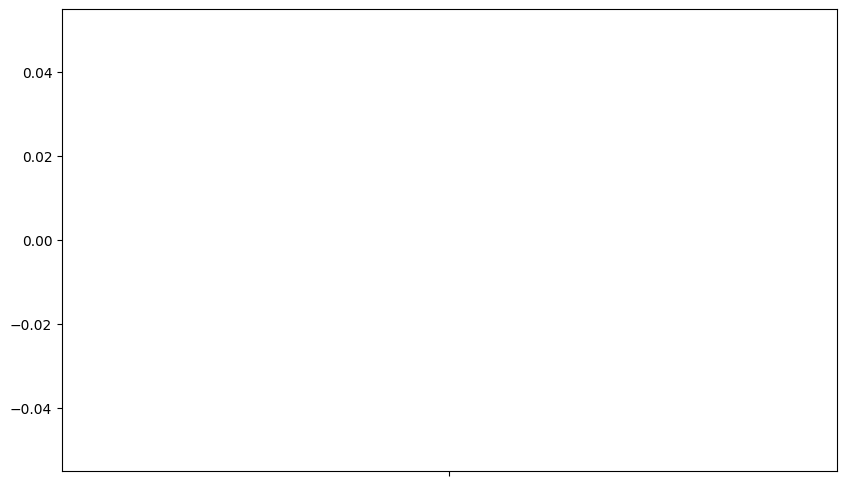

In [156]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='Standard Value', data=filter_df)
plt.title('Box Plot of Features by Class')
plt.xlabel('Class')
plt.ylabel('Feature Value')
plt.show()
#black circles signify outliers

In [ ]:
# checking the range of solubility values - max and min
filter_df['Standard Value'].max()

In [ ]:
filter_df['Standard Value'].min()

In [ ]:
filter_df['log_standard_value'] = -np.log10(filter_df['Standard Value'])

In [ ]:
filter_df['log_standard_value'].max()

In [ ]:
filter_df['log_standard_value'].min()

In [ ]:
def normalize_value(original_value, min_value, max_value):
  normalized_value = (original_value - min_value) / (max_value - min_value)
  return normalized_value
normalized=[]
for i in filter_df['log_standard_value']:
  original_value = i
  min_value = -8.579440597139797
  max_value = 2.6989700043360187

  normalized_value = normalize_value(original_value, min_value, max_value)
  normalized.append(normalized_value)

In [ ]:
#division into classes based on biological analysis :
#RANK 1- high solubility
#RANK 2 - moderate solubility
#RANK 3 - low solubility

solubility_threshold=[]

for i in normalized:
  if float(i) >= 0.6720309150784068:
      solubility_threshold.append("Rank I")
  elif float(i) >= 0.4060359884876476:
      solubility_threshold.append("Rank II")
  else:
      solubility_threshold.append("Rank III")

In [ ]:
#checking the number of compounds in each class
#you can replace rank 1 by rank 2 and 3 to check the number of compunds in those classes
r1,r2,r3=0,0,0
for ele in solubility_threshold:
  if ele=="Rank III":r3+=1
  elif ele == "Rank II": r2+=1
  else: r1+=1

print(r1,r2,r3)

In [ ]:
#adding the solubility class as a column in the dataframe
#first we have to convert list to a series and then join/concatenate it with the earlier dataframe

solubility_class = pd.Series(solubility_threshold, name='solubility_class')
final_df = pd.concat([filter_df, solubility_class], axis=1)
final_df.head()

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors

In [ ]:
# dropping any missing values
cleaned_final = results_df.dropna()
print(f"Original DataFrame shape: {results_df.shape}")
print(f"Cleaned DataFrame shape: {cleaned_final.shape}")

In [ ]:
#checking the number of compounds in each class now(after dropping nan values)
c=0
check=cleaned_final['solubility_class']
for ele in check:
  if ele=='Rank III': c+=1

print(c)

In [ ]:
cleaned_final.head()

In [ ]:
#checking the number of rows and columns
cleaned_final.shape

In [ ]:
from sklearn.preprocessing import RobustScaler # robust to outliers
df_robust = cleaned_final.copy()

# numeric columns excluding 'solubility' which is our target column for prediction by model
numeric_columns = df_robust.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = [col for col in numeric_columns if col != 'Solubility'] # dont scale y!

scaler = RobustScaler()

# scale selected numeric columns
df_robust[numeric_columns] = scaler.fit_transform(df_robust[numeric_columns])

df_robust.head()

In [ ]:
df_robust.shape

In [ ]:
#there are some invalid entries(values tending to infinity) that were giving errors in the subsequent steps, this code is to remove those invalid entries

invalid_count = 0

# Maximum value for float32
float32_threshold = np.finfo(np.float32).max

# Iterate through all rows and columns
rows_to_drop = []

for index, row in df_robust.iterrows():
    for value in row:
        # Check if the value is numeric before applying isinf or comparing thresholds
        if pd.api.types.is_numeric_dtype(type(value)):
            if pd.isnull(value) or np.isinf(value) or abs(value) > float32_threshold:
                rows_to_drop.append(index)
                invalid_count += 1
                break  # Break after marking the row to drop
        else:
            # If it's not numeric, just check for NaN
            if pd.isnull(value):
                rows_to_drop.append(index)
                invalid_count += 1
                break

# Drop rows that contain invalid values
df_robust.drop(rows_to_drop, inplace=True)

# Output the number of invalid entries dropped
print(f"Dropped {invalid_count} invalid entries.")


In [ ]:
df_robust.shape

In [ ]:
#spitting into X features and y target for model
y = df_robust['solubility_class']
X = df_robust.drop(columns=['Smiles', 'Standard Value','solubility_class'])

In [ ]:
print(y.head())
print(X.head())

In [ ]:
#FEATURE SELECTION - can be done using rfe or feature importance
#you can experiment using different number of features and examining the model performance in the subsequent steps

import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Initialize RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the RandomForestClassifier on the entire dataset
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame to map features to their importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Extract the top 25 features
selected_features = importance_df.head(25)['Feature'].tolist()

print("Top n features:", selected_features)


In [ ]:
#X data filter to have only the required columns based in selected features
X_selected = pd.DataFrame(X, columns=selected_features)

X_selected.head()

In [ ]:
#combining X and y as data to split it into train and test
data=X_selected.copy()
data['bioactivity_class']=y

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
target = 'bioactivity_class'

In [ ]:
#WITHOUT TAKING HYPERPARAMETER TUNING INTO CONSIDERATION
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Splitting the data into features (X) and target (y)
X_train = train_data.drop(columns=[target])
y_train = train_data[target]
X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# Initializing the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=25, random_state=42)

# Fitting the model on the training data
rf_classifier.fit(X_train, y_train)

# Making predictions on the test data
y_pred = rf_classifier.predict(X_test)

y_train_pred=rf_classifier.predict(X_train)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


In [ ]:
# Print classification report for training
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

In [ ]:
#WITH HYPERPARAMETER TUNING
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Splitting the data into features (X) and target (y)
X_train = train_data.drop(columns=[target])
y_train = train_data[target]
X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# Initializing the Random Forest Classifier with adjustments
rf_classifier = RandomForestClassifier(
    n_estimators=150,          # Increase number of trees
    max_depth=8,              # Limit maximum depth of trees
    min_samples_split=5,       # Minimum samples to split a node
    min_samples_leaf=3,        # Minimum samples at a leaf node
    random_state=42,
    max_features='sqrt'
)

# Fitting the model on the training data
rf_classifier.fit(X_train, y_train)

# Making predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, you can also evaluate training predictions
y_train_pred = rf_classifier.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))


In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(y_train, y_train_pred))


In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")

    # Calculate learning curve
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')

    # Mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plot learning curve for the RandomForestClassifier
plot_learning_curve(rf_classifier, X_train, y_train)

In [ ]:
! pip install lazypredict
import lazypredict
from lazypredict.Supervised import LazyClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
lazy_class = LazyClassifier()
train,test = lazy_class.fit(X_train, X_test, y_train, y_test)

# Print the results
print(train)

In [ ]:
print(test)

**HYPERPARAMETER TUNING: Some extra information**

To increase the accuracy of the model and reduce overfitting, the hyperparameters of the model can be changed accordingly.

`n_estimators:`

This parameter defines the number of trees in the forest.
Increasing the number of trees can improve the model's performance and stability (reducing variance) but also increases computation time. Too many trees can lead to diminishing returns, so it's essential to find a balance.

`max_depth:`

This sets the maximum depth of each tree.
Limiting the depth can help prevent overfitting by making the trees simpler. If the depth is too shallow, it may lead to underfitting, while a very deep tree can capture noise and lead to overfitting.

`min_samples_split:`

This specifies the minimum number of samples required to split an internal node.
Increasing this value makes the algorithm more conservative, leading to fewer splits and potentially simpler trees, which can reduce overfitting. Conversely, a lower value may capture more complex patterns but can also increase the risk of overfitting.

`min_samples_leaf:`

This sets the minimum number of samples that must be present in a leaf node.
Increasing this value results in larger leaves, which can smooth the model and help reduce overfitting. A lower value allows for more detailed splits, potentially capturing more patterns in the data but risking overfitting.

`random_state:`

Changing the random_state value does not affect the model's performance but alters the randomness in the selection of samples and features, leading to potentially different results across runs. Setting it to a fixed number helps in comparing different model configurations.

`max_features:`

This determines the number of features to consider when looking for the best split.
Using 'sqrt' means that the algorithm will consider the square root of the total number of features. This can help reduce correlation between trees, improving diversity and generalization. Setting it to a higher value (like 'log2' or a specific number) can lead to better model performance, but may also increase overfitting.

There are a few different ways by which we can try hyperparameter tuning

Optuna, GridSearchCV, RandomizedSearchCV: Different combinations of hypermeters are taken and it gives the best parameters

In [ ]:
pip install optuna

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt','log2',None])

    # Create and evaluate the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    score = cross_val_score(model, X_selected, y, n_jobs=-1, cv=3).mean()
    return score

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification

In [ ]:
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
}
randomized_search = RandomizedSearchCV(estimator=rf,
                                       param_distributions=param_dist,
                                       n_iter=50,  # Number of parameter settings to sample
                                       scoring='accuracy',
                                       cv=5,
                                       verbose=2,
                                       n_jobs=-1,
                                       random_state=42)  # For reproducibility
randomized_search.fit(X_train, y_train)
print("Best Parameters:", randomized_search.best_params_)
print("Best Cross-validation Score:", randomized_search.best_score_)
best_rf = randomized_search.best_estimator_
test_score = best_rf.score(X_test, y_test)
print("Test Score:", test_score)

In [ ]:
from google.colab import files
data=files.upload()

In [ ]:
solubility_test = pd.read_csv('solubility_test.csv', names=['name','smiles'])

In [ ]:
solubility_test

In [ ]:
descriptor_names = [desc_name[0] for desc_name in Descriptors._descList] #208, list exists in rdkit, wol wt


calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)


def calculate_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles) # converting smiles to "molecular object"
        if mol is not None:
            return calculator.CalcDescriptors(mol)
        else:
            return [None] * len(descriptor_names)
    except:
        return [None] * len(descriptor_names)


descriptors = solubility_test['smiles'].apply(calculate_descriptors) # calculating descriptors for all smiles in our original dataframe
desc = pd.DataFrame(descriptors.tolist(), columns=descriptor_names) # Adding these descriptors as lists to a new data frame, whose column heading is the descriptor name
results_dt = pd.concat([solubility_test, desc], axis=1) # make a final data frame


In [ ]:
cleaned_dt= results_dt.dropna()
print(f"Original DataFrame shape: {results_dt.shape}")
print(f"Cleaned DataFrame shape: {cleaned_dt.shape}")

In [ ]:
from sklearn.preprocessing import RobustScaler # robust to outliers
robust_dt = cleaned_dt.copy()

# numeric columns excluding 'FDA_APPROVED'
numeric_columns1 = robust_dt.select_dtypes(include=['float64', 'int64']).columns
numeric_columns1 = [col for col in numeric_columns1]

scaler = RobustScaler()

# scale selected numeric columns
robust_dt[numeric_columns1] = scaler.fit_transform(robust_dt[numeric_columns1])

robust_dt

In [ ]:
filter_dt=pd.DataFrame(robust_dt,columns=selected_features)
filter_dt

In [ ]:
dt_pred = rf_classifier.predict(filter_dt)
dt_pred

In [ ]:
name_dt=pd.DataFrame(cleaned_dt,columns=['name','smiles'])
final_dt=name_dt.copy()
final_dt['bioactivity_class']=dt_pred
final_dt

In [ ]:
display_df=pd.concat([final_dt,dt_pred_proba],axis=1)

In [ ]:
#selecting rank 1
rank1_comp=final_dt[final_dt['bioactivity_class']=='Rank I']
rank1_comp

In [ ]:
leads=rank1_comp['smiles']
leads